# QuickDraw - 1 - Separating data 
--- 

# The Quick, Draw! Dataset

The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located. You can browse the recognized drawings on quickdraw.withgoogle.com/data or download the dataset from https://console.cloud.google.com/storage/browser/quickdraw_dataset/?pli=1. 

<img src='https://github.com/googlecreativelab/quickdraw-dataset/raw/master/preview.jpg'/>

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import random
import csv
import json
from scipy.misc import imresize
import os

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')

In [3]:
CLASS_FILE = '/Users/Joshua.Newnham/Documents/Data/quickdraw_dataset/sketch_classes.csv'
SOURCE_DIR = '/Users/Joshua.Newnham/Documents/Data/quickdraw_dataset/full/simplified/'
DEST_DIR = '/Users/Joshua.Newnham/Documents/Data/quickdraw_dataset/sketchrnn_training_data/'
STAGING_DIR = '/Users/Joshua.Newnham/Documents/Data/quickdraw_dataset/staging/'

## Simplify the data 
To reduce the size of the data (and demands of training), we will use a subset of the data; to keep it, *somewhat* similar to the previous model we search for files that contain reference to the labels within the file class_filter_file.  

In [4]:
def migrate_matching_files(class_filter_file, source_dir, dest_dir, 
                           num_samples=11000, 
                           show_progress_bar=True):
    
    if show_progress_bar:
        from ipywidgets import FloatProgress
        from IPython.display import display
    
        floatProgress = FloatProgress(min=0, max=100)
        display(floatProgress)

    # load classes     
    label_filters = []

    with open(class_filter_file, 'r') as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            label_filters.append(row[1])

    # find matching files 
    matching_files = [] 

    for filename in os.listdir(source_dir):
        full_filepath = os.path.join(source_dir, filename).lower()
        if os.path.isfile(full_filepath) and ".ndjson" in full_filepath.lower():
            for label_filter in label_filters:
                if label_filter in full_filepath or label_filter == full_filepath:
                    matching_files.append((label_filter, filename))
                    break 
                    
    print("Found {} matches".format(len(matching_files))) 
    
    seq_lengths = []
        
    # build dataset 
    for matching_file_idx, matching_file in enumerate(matching_files):
        if show_progress_bar:
            floatProgress.value = int((float(matching_file_idx+1)/float(len(matching_files))) * 100) 
        
        matching_label = matching_file[0]
        matching_file = matching_file[1]
        
        full_filepath = os.path.join(source_dir, matching_file) 
        
        with open(full_filepath) as input_f, open(os.path.join(dest_dir, matching_file), "w") as output_f:            
            for idx, line in enumerate(input_f):                                    
                sample = json.loads(line)
                
                seq_lengths.append(len(sample['drawing']))

                output_line = "{" + '"word":"{}", "drawing":{}'.format(sample["word"], sample["drawing"]) + "}\n"
                output_f.write(output_line)                
                
                if idx >= num_samples:
                    break                 
        
    print("Finished")
        
    seq_lengths = np.array(seq_lengths)
    
    print("Stroke lens: Mean {}, Min {}, Max {}".format(
        np.mean(seq_lengths), 
        np.min(seq_lengths), 
        np.max(seq_lengths)))                

In [47]:
migrate_matching_files(class_filter_file=CLASS_FILE, 
                       source_dir=SOURCE_DIR, 
                       num_samples=11000, 
                       dest_dir=STAGING_DIR)

A Jupyter Widget

Found 172 matches
Finished
Stroke lens: Mean 5.595816342277552, Min 1, Max 866


## Subset data 
To reduce the size of the data (and demands of training), we will use a subset of the data. 

In [28]:
def parse_line(ndjson_line):
    """
    Method taken from: 
    https://www.tensorflow.org/versions/master/tutorials/recurrent_quickdraw
    """
    
    # convert string to a JSON object 
    sample = json.loads(ndjson_line)
    label = sample['word']
    strokes = sample['drawing']
    stroke_lengths = [len(stroke[0]) for stroke in strokes]
    total_points = sum(stroke_lengths)
    np_strokes = np.zeros((total_points, 3), dtype=np.float32)
    current_t = 0 
    for stroke in strokes:
        for i in [0,1]:            
            np_strokes[current_t:(current_t + len(stroke[0])), i] = stroke[i]
        print(len(stroke[0]))
        current_t += len(stroke[0])
        np_strokes[current_t - 1, 2] = 1 # stroke end
    
    print(np_strokes)
    
    # preprocessing 
    # 1. size normalisation 
    lower_point = np.min(np_strokes[:, 0:2], axis=0)
    upper_point = np.max(np_strokes[:, 0:2], axis=0)
    scale = upper_point - lower_point
    
    #print("lower_point {}, upper_point {}, scale {}".format(lower_point, upper_point, scale))
    
    scale[scale == 0] = 1 
    np_strokes[:, 0:2] = (np_strokes[:, 0:2] - lower_point) / scale    
    # 2. compute deltas             
    np_strokes = np.hstack((
        np_strokes[1:, 0:2] - np_strokes[0:-1, 0:2], 
        np_strokes[1:,2].reshape(np_strokes.shape[0]-1, 1)))
    
    return np_strokes, label

In [5]:
def load_and_preprocess_data(source_dir, dest_dir, 
                             num_training_samples=10000, # number of training samples
                             num_validation_samples=1000, # number of validation samples 
                             parts=1, # how many files to distribute the data across, 
                             part_num=0, # current part 
                             show_progress_bar=True):
    
    if show_progress_bar:
        from ipywidgets import FloatProgress
        from IPython.display import display
    
        floatProgress = FloatProgress(min=0, max=100)
        display(floatProgress)

    labels = []
    matching_files = []
        
    # create labels 
    for filename in sorted(os.listdir(source_dir)):
        full_filepath = os.path.join(source_dir, filename).lower()
        if os.path.isfile(full_filepath) and ".ndjson" in full_filepath.lower():
            label = filename.replace(".ndjson", '')
            labels.append(label) 
            
            matching_files.append((label, full_filepath))
                    
                    
    print("Found {} matches".format(len(labels)))
    
    label2idx = {label:idx for idx, label in enumerate(labels)}        
    idx2label = {idx:label for label, idx in label2idx.items()}
    
    # write csv 
    with open('{}/labels.csv'.format(dest_dir), 'w') as f:
        writer = csv.writer(f)
        for idx, label in idx2label.items():
            writer.writerow([idx, label])
    
    training_stroke_lengths = []
    validation_stroke_lengths = []        
    
    part_num_training_samples = int(num_training_samples / parts)
    part_num_validation_samples = int(num_validation_samples / parts)
    
    print("Breaking data into {} parts; each with {} training samples and {} validation samples".format(
        parts, part_num_training_samples, part_num_validation_samples))
    
    progress_counter = 0
    progress_count = len(matching_files) * parts                  
    
    while part_num < parts:                
        training_x = []
        validation_x = []
    
        training_y = np.zeros((0,len(matching_files)), dtype=np.int16)
        validation_y = np.zeros((0,len(matching_files)), dtype=np.int16)
        
        line_number = int(part_num * (part_num_training_samples + part_num_validation_samples))
        
        print("Processing part {} of {} - current line number {}".format(
            part_num, parts, line_number))
    
        for matching_file in matching_files:            
            progress_counter += 1
            if show_progress_bar:
                floatProgress.value = int((float(progress_counter)/float(progress_count)) * 100)
            
            matching_label = matching_file[0]
            matching_filename = matching_file[1]
            
            with open(os.path.join(source_dir, matching_filename), 'r') as f:
                for _ in range(line_number):
                    f.readline()                
            
                for i in range(part_num_training_samples):
                    line = f.readline() 
                    strokes, label = parse_line(line)
                    training_stroke_lengths.append(len(strokes))
                
                    training_x.append(strokes)
                
                    y = np.zeros(len(matching_files), dtype=np.int16)
                    y[label2idx[matching_label]] = 1                                                                                     
                    training_y = np.vstack((training_y, y))
                
                for i in range(part_num_validation_samples):
                    line = f.readline() 
                    strokes, label = parse_line(line)
                
                    validation_stroke_lengths.append(len(strokes))
                    
                    validation_x.append(strokes)
                
                    y = np.zeros(len(matching_files), dtype=np.int16)
                    y[label2idx[matching_label]] = 1
                    validation_y = np.vstack((validation_y, y))
                        
        training_x = np.array(training_x) 
        validation_x = np.array(validation_x)        
        
        part_num += 1
    
        # save .npy            
        np.save(os.path.join(dest_dir, "train_{}_x.npy".format(part_num)), training_x)
        np.save(os.path.join(dest_dir, "train_{}_y.npy".format(part_num)), training_y)
        
        np.save(os.path.join(dest_dir, "validation_{}_x.npy".format(part_num)), validation_x)
        np.save(os.path.join(dest_dir, "validation_{}_y.npy".format(part_num)), validation_y)
    
    training_stroke_lengths = np.array(training_stroke_lengths)
    validation_stroke_lengths = np.array(validation_stroke_lengths)
    
    np.save(os.path.join(dest_dir, "train_stroke_lengths.npy"), training_stroke_lengths)
    np.save(os.path.join(dest_dir, "validation_stroke_lengths.npy"), validation_stroke_lengths)          
        
    print("Finished")
    
    print("Training stroke lens: Mean {}, Min {}, Max {}".format(
        np.mean(training_stroke_lengths), 
        np.min(training_stroke_lengths), 
        np.max(training_stroke_lengths)))
    
    print("Validation stroke lens: Mean {}, Min {}, Max {}".format(
        np.mean(validation_stroke_lengths), 
        np.min(validation_stroke_lengths), 
        np.max(validation_stroke_lengths)))        
                

In [6]:
load_and_preprocess_data(source_dir=STAGING_DIR, 
                         dest_dir=DEST_DIR,
                         num_training_samples=10000, 
                         num_validation_samples=1000,
                         parts=5, 
                         part_num=0)

A Jupyter Widget

Found 172 matches
Breaking data into 5 parts; each with 2000 training samples and 200 validation samples
Processing part 0 of 5 - current line number 0
Processing part 1 of 5 - current line number 2200
Processing part 2 of 5 - current line number 4400
Processing part 3 of 5 - current line number 6600
Processing part 4 of 5 - current line number 8800
Finished
Training stroke lens: Mean 45.57787906976744, Min 1, Max 1739
Validation stroke lens: Mean 45.506872093023254, Min 1, Max 1278


--- 

In [8]:
train_stroke_lens = np.load(os.path.join(DEST_DIR, "train_stroke_lengths.npy"))

In [9]:
train_stroke_lens.shape

(1720000,)

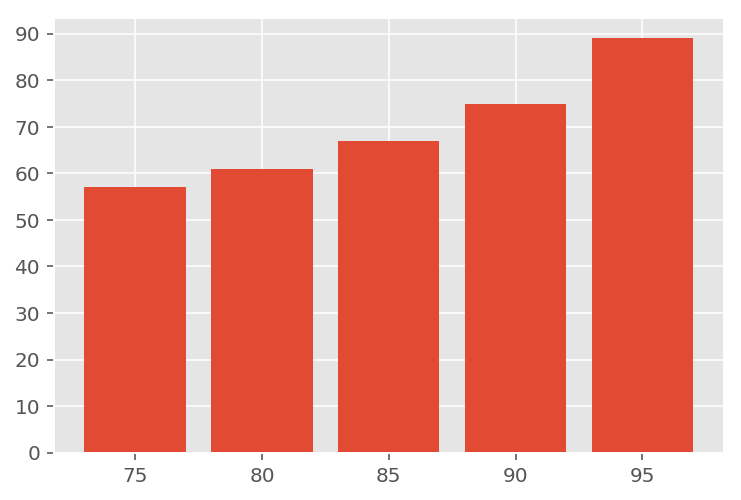

In [10]:
percentile = [75, 80, 85, 90, 95]

lines_percentiles = [np.percentile(train_stroke_lens, p) for p in percentile]

plt.bar(range(len(lines_percentiles)), 
        lines_percentiles, align='center')
plt.xticks(range(len(percentile)), [p for p in percentile])
plt.yticks(range(0, 100, 10))
plt.show()

Based on the percentiles; a sequence length of around **70/75** will encapsulate almost 90% of the sequences  